#Artificial Neural Networks and Deep Learning
#Homework 2: Image Segmentation

Students:

*   Julián Jiménez: 10657117
*   Samuel Polo: 10670388



In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


In [2]:
#Code to bring data from MyGoogleDrive to Python Notebook.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import os

In [4]:
# Set the seed for random operations. 
# This allows our process to be reproducible. 

SEED = 1234
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Get current working directory
cwd = os.getcwd()
print(cwd)

/content


In [5]:
!unzip /content/drive/My\ Drive/Datasets/Segmentation_Dataset.zip

Archive:  /content/drive/My Drive/Datasets/Segmentation_Dataset.zip
  inflating: Segmentation_Dataset/test/images/img/1029.tif  
  inflating: Segmentation_Dataset/test/images/img/1030.tif  
  inflating: Segmentation_Dataset/test/images/img/1031.tif  
  inflating: Segmentation_Dataset/test/images/img/1032.tif  
  inflating: Segmentation_Dataset/test/images/img/1033.tif  
  inflating: Segmentation_Dataset/test/images/img/1034.tif  
  inflating: Segmentation_Dataset/test/images/img/1035.tif  
  inflating: Segmentation_Dataset/test/images/img/1144.tif  
  inflating: Segmentation_Dataset/test/images/img/1145.tif  
  inflating: Segmentation_Dataset/test/images/img/1146.tif  
  inflating: Segmentation_Dataset/test/images/img/1147.tif  
  inflating: Segmentation_Dataset/test/images/img/1148.tif  
  inflating: Segmentation_Dataset/test/images/img/1149.tif  
  inflating: Segmentation_Dataset/test/images/img/1150.tif  
  inflating: Segmentation_Dataset/test/images/img/1151.tif  
  inflating: Segm

In [6]:
!ls Segmentation_Dataset/
!rm -rf Segmentation_Dataset/validation

test  training


In [0]:
#Set the directories for all, training and validation images.

dataset_dir = os.path.join(cwd, 'Segmentation_Dataset')
training_dir = os.path.join(dataset_dir,'training')
valid_dir = os.path.join(dataset_dir,'validation')

#**Validation Directory Creation**

This code is used to create the validation directory and fill it up with images from all the classes. The validation set is created with stratified sampling since all classes are not represented equally in the given dataset. In this way from each class we select the same proportion of images. This is done to reduce sampling error and allow all classes to be represented in the validation set.

In [0]:
#Creates validation directory if it does not exist already.
_ = os.makedirs(valid_dir, exist_ok=True)

In [0]:
#Proportion for Hold-out set validation.
train_valid_split = 0.2

#Fills the validation set 
subfolders = [f.path for f in os.scandir(training_dir) if f.is_dir() ] 
flag = True
for subfold in subfolders:
  head_tail = os.path.split(subfold)
  _ = os.makedirs(os.path.join(valid_dir,head_tail[1],'img'), exist_ok=True)
  list_files = [name for name in os.scandir(os.path.join(subfold,'img')) if os.path.isfile(name)]
  num_files = len(list_files)
  if flag:
     rand = np.random.choice(num_files, int(num_files*train_valid_split) ,replace=False)
     flag = False
  for num in rand:
    file_name = os.path.split(list_files[num])
    os.rename(list_files[num],os.path.join(valid_dir,head_tail[1],'img',file_name[1]))

#**Training and Validation Generators and Datasets**

In [0]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = False

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    train_img_data_gen = ImageDataGenerator(rotation_range=10,
                                            width_shift_range=10,
                                            height_shift_range=10,
                                            zoom_range=0.3,
                                            horizontal_flip=True,
                                            vertical_flip=True,
                                            fill_mode='constant',
                                            cval=0) 
    train_mask_data_gen = ImageDataGenerator(rotation_range=10,
                                             width_shift_range=10,
                                             height_shift_range=10,
                                             zoom_range=0.3,
                                             horizontal_flip=True,
                                             vertical_flip=True,
                                             fill_mode='constant',
                                             cval=0,
                                             rescale=1./255)
      #Use rescale=1./255 in the mask ImageDataGenerator to obtain binary values {0, 1} as target.
else:
    train_img_data_gen = ImageDataGenerator()
    train_mask_data_gen = ImageDataGenerator(rescale=1./255)

# Create validation and test ImageDataGenerator objects
valid_img_data_gen = ImageDataGenerator()
valid_mask_data_gen = ImageDataGenerator(rescale=1./255)

In [11]:
# Create generators to read images from dataset directory
# -------------------------------------------------------
dataset_dir = os.path.join(cwd, 'Segmentation_Dataset')

# Batch size
bs = 6

# img shape
img_h = 256
img_w = 256

num_classes=2

# Training
# Two different generators for images and masks
# ATTENTION: here the seed is important!! We have to give the same SEED to both the generator
# to apply the same transformations/shuffling to images and corresponding masks
training_dir = os.path.join(dataset_dir, 'training')
train_img_gen = train_img_data_gen.flow_from_directory(os.path.join(training_dir, 'images'),
                                                       target_size=(img_h, img_w),
                                                       batch_size=bs, 
                                                       class_mode=None, # Because we have no class subfolders in this case
                                                       shuffle=True,
                                                       interpolation='bilinear',
                                                       seed=SEED)  
train_mask_gen = train_mask_data_gen.flow_from_directory(os.path.join(training_dir, 'masks'),
                                                         target_size=(img_h, img_w),
                                                         batch_size=bs,
                                                         color_mode = 'grayscale',
                                                         class_mode=None, # Because we have no class subfolders in this case
                                                         shuffle=True,
                                                         interpolation='bilinear',
                                                         seed=SEED)
train_gen = zip(train_img_gen, train_mask_gen)

# Validation
validation_dir = os.path.join(dataset_dir, 'validation')
valid_img_gen = valid_img_data_gen.flow_from_directory(os.path.join(validation_dir, 'images'),
                                                       target_size=(img_h, img_w),
                                                       batch_size=bs, 
                                                       class_mode=None, # Because we have no class subfolders in this case
                                                       shuffle=False,
                                                       interpolation='bilinear',
                                                       seed=SEED)
valid_mask_gen = valid_mask_data_gen.flow_from_directory(os.path.join(validation_dir, 'masks'),
                                                         target_size=(img_h, img_w),
                                                         batch_size=bs, 
                                                         color_mode='grayscale',
                                                         class_mode=None, # Because we have no class subfolders in this case
                                                         shuffle=False,
                                                         interpolation='bilinear',
                                                         seed=SEED)
valid_gen = zip(valid_img_gen, valid_mask_gen)

Found 6118 images belonging to 1 classes.
Found 6118 images belonging to 1 classes.
Found 1529 images belonging to 1 classes.
Found 1529 images belonging to 1 classes.


In [0]:
# Create Dataset objects
# ----------------------

# Training
# --------
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, img_h, img_w, 1]))

def prepare_target(x_, y_):
    y_ = tf.cast(y_, tf.int32)
    return x_, y_

train_dataset = train_dataset.map(prepare_target)

# Repeat
train_dataset = train_dataset.repeat()

# Validation
# ----------
valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, img_h, img_w, 1]))
valid_dataset = valid_dataset.map(prepare_target)

# Repeat
valid_dataset = valid_dataset.repeat()

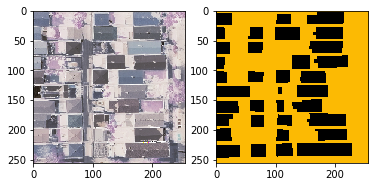

In [21]:
# Let's test data generator [Current Testing Code]
# -------------------------
import time
import matplotlib.pyplot as plt

%matplotlib inline

fig, ax = plt.subplots(1, 2)
fig.show()

# Assign a color to each class
colors_dict = {}
colors_dict[0] = [252, 186, 3]  # foreground
colors_dict[1] = [0, 0, 0]  # background
colors_dict[2] = [3, 82, 252] # contours

iterator = iter(train_dataset)

for _ in range(100):
    augmented_img, target = next(iterator)
    augmented_img = augmented_img[0]   # First element
    augmented_img = augmented_img * 255  # denormalize
    
    target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)
    
    # Assign colors (just for visualization)
    target_img = np.zeros([target.shape[0], target.shape[1], 3])
    
    target_img[np.where(target == 0)] = colors_dict[0]
    target_img[np.where(target == 1)] = colors_dict[1]
    target_img[np.where(target == 2)] = colors_dict[2]
    
    ax[0].imshow(np.uint8(augmented_img))
    ax[1].imshow(np.uint8(target_img))
    
    fig.canvas.draw()
    time.sleep(1)

In [22]:
np.unique(target_img)

array([  0.,   3., 186., 252.])

#**Convolutional Neural Network**

##**Encoder-Decoder**

In [0]:
# Create Model
# ------------

def create_model(depth, start_f, num_classes, dynamic_input_shape):

    model = tf.keras.Sequential()
    
    # Encoder
    # -------
    for i in range(depth):
        
        if i == 0:
            if dynamic_input_shape:
                input_shape = [None, None, 3]
            else:
                input_shape = [img_h, img_w, 3]
        else:
            input_shape=[None]
        
        model.add(tf.keras.layers.Conv2D(filters=start_f, 
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same',
                                         input_shape=input_shape))
        model.add(tf.keras.layers.ReLU())
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

        start_f *= 2

    # Decoder
    # -------
    for i in range(depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2D(filters=start_f // 2,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))

        model.add(tf.keras.layers.ReLU())

        start_f = start_f // 2

    # Prediction Layer
    # ----------------
    model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='softmax'))
    
    return model

In [16]:
model = create_model(depth=4, 
                     start_f=4, 
                     num_classes=2, 
                     dynamic_input_shape=False)

# Visualize created model as a table
model.summary()

# Visualize initialized weights
#model.weights

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 4)       112       
_________________________________________________________________
re_lu (ReLU)                 (None, 256, 256, 4)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 4)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       296       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        1

#**Prepare the models for Training**

In [0]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) 
# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

#**Training with callbacks**

In [18]:
import os
from datetime import datetime

# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'segmentation_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    callbacks.append(es_callbacks)


model.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=len(train_img_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_img_gen), 
          callbacks=callbacks)

# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

Train for 1020 steps, validate for 255 steps
Epoch 1/100
1020/1020 [==============================] - 57s 56ms/step - loss: 0.6259 - accuracy: 0.6938 - val_loss: 0.6209 - val_accuracy: 0.6878
Epoch 2/100
1020/1020 [==============================] - 51s 50ms/step - loss: 0.6140 - accuracy: 0.6964 - val_loss: 0.6211 - val_accuracy: 0.6878
Epoch 3/100
1020/1020 [==============================] - 51s 50ms/step - loss: 0.6136 - accuracy: 0.6968 - val_loss: 0.6211 - val_accuracy: 0.6878
Epoch 4/100
1020/1020 [==============================] - 51s 50ms/step - loss: 0.6140 - accuracy: 0.6964 - val_loss: 0.6209 - val_accuracy: 0.6878
Epoch 5/100
1020/1020 [==============================] - 51s 50ms/step - loss: 0.6139 - accuracy: 0.6965 - val_loss: 0.6212 - val_accuracy: 0.6878
Epoch 6/100
1020/1020 [==============================] - 51s 50ms/step - loss: 0.6136 - accuracy: 0.6969 - val_loss: 0.6211 - val_accuracy: 0.6878
Epoch 7/100
1020/1020 [==============================] - 51s 50ms/step - 

#**Test model**

In [0]:
# Just for exercise try to restore a model after training it
# !! Use this just when restoring model.. 
# ---------------------------------------
restore_model = True
if restore_model:
    model = create_model(depth=4, 
                         start_f=4, 
                         num_classes=3, 
                         dynamic_input_shape=True)

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                  metrics=['accuracy'])  # Needed for loading weights

    model.load_weights(os.path.join(
        cwd, 'segmentation_experiments', 'EXP_FOLDER', 'ckpts', 'cp_60.ckpt'))  # use this if you want to restore saved model
# ----------------------------------------

eval_out = model.evaluate(x=test_dataset,
                          steps=len(test_img_gen),
                          verbose=0)

eval_out

#**Compute Prediction**

In [0]:
import time
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib notebook

# Cycle over test images

test_img_dir = os.path.join(test_dir, 'images', 'img')
test_mask_dir = os.path.join(test_dir, 'masks', 'img')

img_filenames = next(os.walk(test_img_dir))[2]

fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()

# Assign a color to each class
colors_dict = {}
colors_dict[0] = [252, 186, 3]  # foreground
colors_dict[1] = [0, 0, 0]      # background
colors_dict[2] = [3, 82, 252]   # contours

for img_filename in img_filenames:
    
    mask_filename = img_filename[:-4] + '.png'
    
    img = Image.open(os.path.join(test_img_dir, img_filename))
    img = img.resize((128, 128))
    mask = Image.open(os.path.join(test_mask_dir, mask_filename))
    mask = mask.resize((128, 128))
    
    img_arr = np.expand_dims(np.array(img), 0)
    
    out_softmax = model.predict(x=img_arr / 255.)
    
    # Get predicted class as the index corresponding to the maximum value in the vector probability
    predicted_class = tf.argmax(out_softmax, -1)
    predicted_class = predicted_class[0]
    
    target = np.array(mask)
    target -= 1    ## to get classes 0,1,2 instead of 1,2,3
    
    print(target.shape)
    
    # Assign colors (just for visualization)
    target_img = np.zeros([target.shape[0], target.shape[1], 3])
    prediction_img = np.zeros([target.shape[0], target.shape[1], 3])
    
    target_img[np.where(target == 0)] = colors_dict[0]
    target_img[np.where(target == 1)] = colors_dict[1]
    target_img[np.where(target == 2)] = colors_dict[2]
    
    prediction_img[np.where(predicted_class == 0)] = colors_dict[0]
    prediction_img[np.where(predicted_class == 1)] = colors_dict[1]
    prediction_img[np.where(predicted_class == 2)] = colors_dict[2]
    
    ax[0].imshow(np.uint8(img_arr[0, ...]))
    ax[1].imshow(np.uint8(target_img))
    ax[2].imshow(np.uint8(prediction_img))
    
    fig.canvas.draw()
    time.sleep(1)